# ML 
multinomial classification

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
import sys  
sys.path.insert(0, '/Volumes/Transcend/DataScience/data_bootcamp/data/cap_data')

In [3]:
import Metrica_IO_CF as mio
import Metrica_Viz_CF_ADJ as mviz
import Metrica_Viz_CF as mviz_old
import Metrica_Velocities_CF as mvel
import matplotlib.animation as manimation

In [4]:
# import numpy
import numpy as np

# import linear_model and datasets from sklearn
from sklearn import linear_model
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split

# import GridSearchCV from sklearn
from sklearn.model_selection import GridSearchCV

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score

# multi-class classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [5]:
DATADIR = "/Volumes/Transcend/DataScience/data_bootcamp/data/cap_data"

In [6]:
game_id='/game_2'

In [7]:
tracking_home=pd.read_csv(DATADIR+game_id+'/tracking_home.csv')

In [8]:
tracking_away=pd.read_csv(DATADIR+game_id+'/tracking_away.csv')

In [9]:
tracking_home.shape

(151412, 103)

In [10]:
tracking_away.shape

(151412, 85)

In [11]:
events=pd.read_csv(DATADIR+game_id+'/events_cleaned.csv')

In [12]:
tracking_home['Team']='Home'
tracking_away['Team']='Away'

In [13]:
tracking_all=tracking_home.merge(tracking_away.drop(['Time [s]','Period','ball_x',
                                                                                 'ball_y','ball_z','ball_speed'],axis=1),how='left',on='frameIdx')

In [14]:
team=[]
for i in range(len(tracking_all)):
    if tracking_all['Team_x'].iloc[i]=='Home':
        team.append('Home')
    else:
        team.append('Away')

In [15]:
tracking_all=tracking_all.drop(['Team_x','Team_y'],axis=1)

In [16]:
tracking_all['Team']=team

In [18]:
tracking_all=tracking_all.set_index('frameIdx')

In [19]:
tracking_all.shape

(151412, 181)

# First model - 3 types, pass, goal, other

### Critical Steps:
1. Label Data Correctly - such that there are labels from the start of a pass to the end of a pass
 - this is going to take a hot minute
2. Split data into train/test sets
  - 70/30
3. Use sliding window to reshape data into usable format
 - use a 2.5 s window length
 - choose % overlapping 
4. train model
 - model will need to be chosen - deep learning is best but it may be too much 
 - get going using random forest or something
 - data needs to be shaped appropriately for this to work
5. evaluate model
 - accuracy
 - confusion matrix
6. dicuss next steps for improvements, applications
 - reduce dataset down to much less components (closest 3 players on each team to the ball or something)
 - deep learning using CNN or RNN,LSTM

## 1. Label Data Correctly

In [20]:
import seaborn as sns

<AxesSubplot:xlabel='count', ylabel='Subtype'>

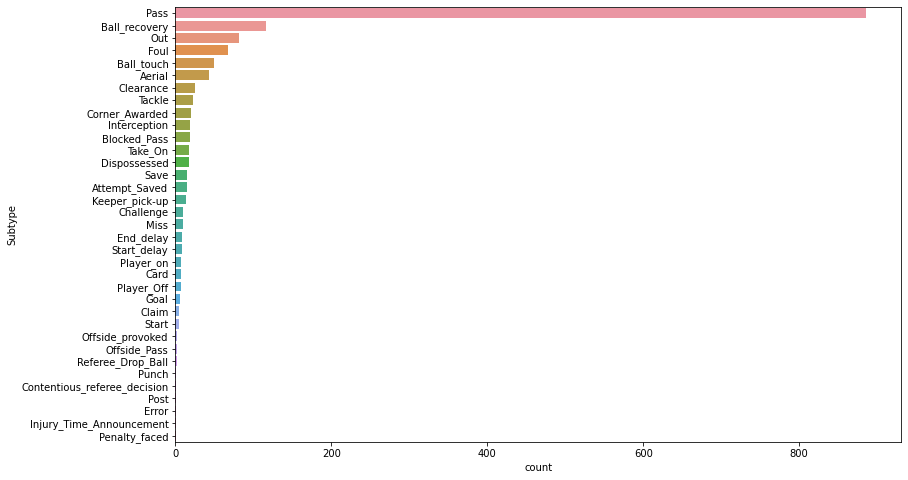

In [21]:
plt.figure(figsize=(13,8))
sns.countplot(y='Subtype', data=events, order = events['Subtype'].value_counts().index)

In [23]:
tracking_all['Labels']=np.nan

In [27]:
tracking_all['End_X']=np.nan
tracking_all['End_Y']=np.nan

## Watching the game and manually labelling - Starting with second half

In [61]:
def label_events(tracking_all,start_f,end_f,player_from,player_to,label):
    '''Need tracking (df), start frame(int), end frame (int), 
    player from(list of player name), player to (list of player name)'''
    
    frames=np.arange(start_f,end_f+1,1)
    player_from=player_from*len(frames)
    player_to=player_to*len(frames)
    labels=label*len(frames)
    df=pd.DataFrame([frames,player_from, player_to,labels]).T
    df.columns=['frameIdx','From','To','Event_Type']
    return tracking_all.reset_index().merge(df,how='inner',on='frameIdx').set_index('frameIdx')    

In [64]:
label_events(tracking_all,0,5,['10'],['21'],['Pass'])

home_3_x  home_3_y  home_3_z  home_7_x  home_7_y  home_7_z  \
frameIdx                                                               
0              NaN       NaN       NaN      0.99     -9.30       0.0   
1              NaN       NaN       NaN      0.99     -9.29       0.0   
2              NaN       NaN       NaN      0.99     -9.27       0.0   
3              NaN       NaN       NaN      1.00     -9.26       0.0   
4              NaN       NaN       NaN      1.00     -9.25       0.0   
5              NaN       NaN       NaN      1.00     -9.23       0.0   

          home_9_x  home_9_y  home_9_z  home_11_x  ...  away_8_vx  away_8_vy  \
frameIdx                                           ...                         
0            -0.42     23.78       0.0        NaN  ...        NaN        NaN   
1            -0.48     23.79       0.0        NaN  ...        NaN        NaN   
2            -0.56     23.79       0.0        NaN  ...        NaN        NaN   
3            -0.64     23.80       0.0        NaN  ...        NaN        NaN   
4            -0.74     23.80       0.0        NaN  ...       -0.5   0.357143   
5            -0.84     23.80       0.0        NaN  ...       -0.5   0.321429   

          away_8_speed  Team  Labels  End_X  End_Y  From  To  Event_Type  
frameIdx                                                                  
0                  NaN  Home     NaN    NaN    NaN    10  21        Pass  
1                  NaN  Home     NaN    NaN    NaN    10  21        Pass  
2                  NaN  Home     NaN    NaN    NaN    10  21        Pass  
3                  NaN  Home     NaN    NaN    NaN    10  21        Pass  
4             0.614452  Home     NaN    NaN    NaN    10  21        Pass  
5             0.594404  Home     NaN    NaN    NaN    10  21        Pass  

[6 rows x 187 columns]

## This is misleading because much of the subtype column is null. NOW need to fill those null values.

# Remove columns that don't matter or are obviously correlated
- Time

In [ ]:
num_scaled = StandardScaler().fit_transform(X_num)

In [ ]:
###### SPLIT DATA #######
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0) # 70% training and 30% test